$Gaussian$ $Beam$ $Experiment$


Welcome to our setup of the Gaussian laser beam experiment! We are measuring the waist of a laser beam; the theory behind it can be found in several textbooks on lasers and optics. We used a HeNe diode laser from Thorlabs, with an output waist of 1.75 mm. After reflecting the beam off two mirrors, we focused it with a 75mm lens onto a razor blade, which was mounted onto two millimeter stages. One was controlled with a K cube stepper motor and it moved the blade perpendicular to laser path, and the other was moved by hand in the direction of the laser beam. We collected the beam with a DET36A photodetector, which was hooked up to a USB-6211 DAQ. We obtained this data by running a labview program that gave us the data from our DAQ. 

Some useful things we discovered along the way included

* We used an optical filter with ND=1.6 in order to avoid saturating the detector (Output voltage should be ~200mV)
* We connected our detector to the DAQ in differential mode; this required two 56 kOhm resistors for this specific device
* Using a newer razor blade yielded drastically better data
* Make sure that all the lens are positioned correctly
* Using a second lens to focus onto the detector is a good idea; you do not want the spot from the laser to be larger than your detector
* Make sure your DAQ is set up and connected properly in differential mode. Check the NI website for instructions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os.path
import scipy as sp
from scipy import special 
from scipy.optimize import curve_fit
%matplotlib inline
def my_erfc(x,a,w,p0): return p0*.5*(special.erfc(math.sqrt(2)*(x-a)/w))

* to do list : change location to r.\data as mentioned, clean up naming conventions and reduce number of input variables.

$ User$  $Inputs $

Below are the user inputs; the wavelength of the laser, the z values at which these measurements were taken, the number of measurements per value, and the total number of measurements. Since changing the z value was done by hand, it is not possible to simplify this step. The directory with the data should also be specified below. In our case, we named our files "zxx.csv", where xx was the number of the measurement. It is important to note that we took 5 data points at 7.6, then we took 5 at 7.65, etc. If, for instance, one took 5 measurements (z00-z04 for us) at 7.65, and then 5 measurements at 7.6 (z05-z10 for us), then one would have to switch the order of 7.6 and 7.65 in this z_val vector. 

In [3]:
wavelength=.000532
z_val=[7.6,7.65,7.7,7.75,7.8,7.85,7.9,7.95,8,8.05,8.1,8.15,8.2,8.25,8.3,8.35]
num_z=5
total_num_z=80

In [8]:
filepath = r".\data"
dir_name = os.path.normpath(filepath)
w=[]
x0=[]
P=[]
errors=[]
stderror=[]
#These indices below have to match the indices of the z_val below 
for i in range(0,total_num_z):
    filename= "z{:02d}".format(i)
    filename_suffix = "csv"
    filepath = os.path.join(dir_name, filename + "." + filename_suffix)
    data = np.genfromtxt(filepath,skip_header=0,delimiter=',')
    xdata=data[:,0]
    ydata=data[:,1]
    ydata=[x-ydata[-1] for x in ydata] 
    guess=(8.28,.01,.4)
    ydata=np.array(ydata)
    params,conv = curve_fit(my_erfc,xdata,ydata,guess)
    a,wz,p0= params
    w.append(wz)
    x0.append(a)
    P.append(p0)
    errors.append(conv)
    dw=np.sqrt(conv[2,2])
    stderror.append(dw/wz)
print('The largest standard error in w is %0.3f' %max(stderror),'.')
if max(stderror)>.3:
    print('The standard error is too large!')

The largest standard error in w is 0.205 .


In the first cell, the complementary error function was defined as:

$$P(x,z)=\frac{P_0}{2}\rm{erfc}\left ( \frac{\sqrt{2}(x-x_0)}{w(z)} \right )$$

We fit our erfc at each z position, extracting the waist, $x_0$, and $P_0$ parameters each time.

The array 'params' contains three variables for fitting the complementary function:

* x is the distance of the blade from the initial position (mm)
* x0 (in mm) -- the position at which half of the beam is blocked.
* w = waist of beam (in $\mu$m) (as a radius -- 2w is the diameter)
* P = full power when beam is unblocked (Proportional to voltage from photodetector)

In the block above, these three parameters are extracted from a set of data for one or multiple z measurements. Data is imported from the chosen directory into numpy arrays called w,x0,P0. The last data point is taken as the background noise and subtracted out. The covariance matrices are saved for each z data point in the list called "errors", and the standard error for w is saved in an array called stderror. Sometimes, curve_fit will not work; to fix this, it is important to help the curve_fit function by providing a good guess for the fit values; often times, it will return values of 1 or other unreasonable fits if a guess is not provided. A test run is recommended to get a feel for where $x_0$ might be, since that seems to be the part the program struggles with. Another important thing to note is that the step size matters and getting about 8-12 data points during the "descent" part of the erfc is key to a good fit. If the fits are not working for multiple data sets, one can try fitting only one and graphing it with the following code to troubleshoot. If it is obvious that the fit is bad, mess with the guess to try and improve it. 

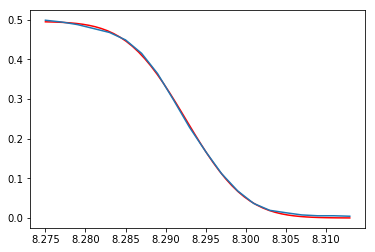

In [43]:
#Troubleshooting
x=np.linspace(xdata[0],xdata[-1])
#These should be the starting and stopping points of your data taking, respectively.
xdata=data[:,0]
ydata=data[:,1]
guess=(8.3,.01,.4)
params,conv = curve_fit(my_erfc,xdata,ydata,guess)
a,wz,p0= params
plt.plot(x,my_erfc(x,a,wz,p0),'r')
plt.plot(xdata,ydata)

The z positions should be recorded in z_val, above. 

These waist values are then plotted as a function of z position and fitted using Gaussian beam theory:

$$w(z) = w_0 \sqrt{1+\left ( \theta \frac{(z-z_0)}{w_0} \right )^2}$$

In order to make the fitting simpler, we square both sides of this equation and fit a quadratic polynomial:

$$(w(z))^2 = [\theta^2]z^2 + [-2 \theta^2 z_0]z + [w_0^2+\theta^2 z_0^2]$$

* The $w_0$ is the waist; it is one of the parameters that gives us everything and it is the thinnest the laser beam gets.

* The $\theta$ is the beam divergence near the waist; in short, it explains how much the beam converges coming into the waist and how much it diverges coming out of it. 

* The $z_0$ is the z position of the waist on the millimeter stage. It can be used for reference but it isn't too important. 

* Z is the distance parallel to the laser beam; it is adjusted by hand. 

Below we plot the $w^2$ data just to make sure that our units are correct and to ensure that the data is indeed parabolic. I have also taken several measurements at each w in order to reduce noise and averaged over them to get one w for each z point. The number of measurements at each w was defined above as num_z.

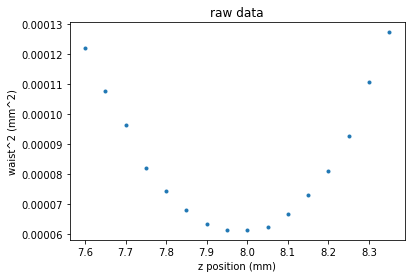

In [44]:
w=np.array(w)
w_new=[]
for n in range(0,total_num_z,math.floor(total_num_z/len(z_val))):#good
    w_average=(np.cumsum(w[n:n+num_z]))/num_z#good
    w_new.append(w_average[-1])
wsqd=[y**2 for y in w_new]
plt.plot(z_val,wsqd,'.')
plt.xlabel('z position (mm)')
plt.ylabel('waist^2 (mm^2)')
plt.title('raw data')

The following two cells fit our data to a parabola and extracts the values of interest as per the equation above. The "coeffs" array contains the coefficients to the quadratic fit in descending order. It returns $\theta, z_0, w_0 $ in radians, mm and mm, respectively. The covariance matrix for this fit is saved as covar to be used later in error analysis.

In [45]:
coeffs,covar=np.polyfit(z_val,wsqd,2,cov=True)
# from 13-appendix-f.pdf (p. 484)
theta=np.sqrt(coeffs[0])
z0=-coeffs[1]/(2*coeffs[0])
w0=np.sqrt(coeffs[2]-coeffs[0]*(z0**2))

Below is a plot of the fit versus the data. On the left is a graph of $w^2$ vs z, and on the right, w vs z. We have a parabola with the fitted parameters; ideally, a few data points should be taken away from the waist and most should be taken very close to it. It also helps to take equal amounts of data points on both sides of the waist for a better fit. 

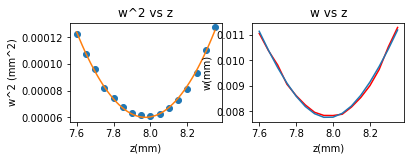

In [46]:
x=np.linspace(z_val[0],z_val[-1])
plt.subplot(2,2,1)
plt.plot(z_val,wsqd,'o')
plt.plot(x,coeffs[0]*x**2+coeffs[1]*x+coeffs[2])
plt.title('w^2 vs z')
plt.xlabel('z(mm)')
plt.ylabel('w^2 (mm^2)')
w_data=[np.sqrt(x) for x in wsqd]
plt.subplot(2,2,2)
plt.title('w vs z')
plt.xlabel('z(mm)')
plt.ylabel('w(mm)')
plt.plot(z_val,w_data,'r-')
z1=np.array([z-z0 for z in z_val])
plt.plot(sorted(z_val),w0*np.sqrt(1+(theta*(sorted(z1)/w0))**2))
#plt.savefig('w^2 vs Z.png',dpi=400)


Finally, from the relation for Gaussian beams (13-appendix-f, p. 480), $M^2=\theta \pi \tfrac{w_0}{\lambda}$, $M^2$ for the laser can be found. Another parameter of interest is $z_R$, Rayleigh's range, also known as the confocal region. It is given by $z_R=\frac{\pi w_0^2}{M^2 \lambda}$; the following cells give $z_R$ in millimeters, provided the wavelength of the laser in those same units, which should be provided in the beginning of the program. 

Below is a block of code that lists the results and the errors ($\pm$ 2$\sigma$) in the values of interest, such as $w_0$, $\theta$, $M^2$, and $z_R$. The covariance matrix from the parabolic fit has been saved to covar; the diagonal entries are the variances in the second, first and zeroth order terms. I call the variances in the fit parameters a,b,c from $$ax^2+bx+c$$ da, db, dc. In our case, we are ignoring any possible covariances between our three variables. Since variances of random variables add, we can use the rules for propagation of error to find d$\theta$, d$M^2$, d$z_R$, and d$w_0$ from the following equations:

$(\mathrm df)^{2} = (\frac{\partial f }{\partial \theta })^{2}{\mathrm d{\theta}}^{2}  + (\frac{\partial f} {\partial z _{0}})^{2}{\mathrm d{z_{0}}^{2}} + (\frac{\partial f }{\partial w _{0} })^{2}{\mathrm d{w_0}}^{2} $

$da^{2} = (2\theta d\theta)^{2}$

$d\theta = \frac{da}{2\theta}$

$db^{2} = (-4\theta z_{0} d\theta)^{2}+ (-2\theta^{2} dz_{0})^{2}$

$dz_{0} = \sqrt{\frac{(db^{2}-(4\theta z_{0} d\theta)^{2})}{4\theta^{4}}}$

$dc^{2} = (2\theta z_{0}^{2} d\theta)^{2}+(2\theta^{2} z_{0} dz_{0})^{2}+(2w_{0} dw_{0})^{2}$

$dw_{0}= \frac{1}{2w_{0}}\sqrt{ (dc^{2}-(2\theta z_{0}^{2} d\theta)^{2}+(2w_{0}dw_{0})^{2})}$

$dM^2=\frac{\pi}{\lambda}\sqrt{{\theta dw_0}^2+{w_0 d{\theta}}^2}$

$dz_R=\frac{\pi}{\lambda}\sqrt{({{\frac{2 w_0 dw_0}{M^2}}})^2+(\frac{2 w_0 d M^2}{M^2})^2}$

In [48]:
Msqd=theta*np.pi*w0/wavelength
z_r=np.pi*w0**2/(Msqd*wavelength)
d_theta=np.sqrt(covar[0,0]/(2*theta)**2)
d_z0=np.sqrt(abs(covar[1,1]-((-4*theta*z0*d_theta)**2))/(2*theta)**2)
d_w0=np.sqrt(abs(covar[2,2]-(2*theta*z0**2*d_theta)**2-(2*theta**2*z0*d_z0)**2)/(2*w0)**2)
d_Msqd=np.pi/wavelength*np.sqrt((theta*d_w0)**2+(w0*d_theta)**2)
d_z_r=np.pi/wavelength*np.sqrt((2*w0*d_w0/Msqd)**2+((w0/Msqd)**2*d_Msqd)**2)
error_theta=2*d_theta
error_z0=2*d_z0
error_w0=2*d_w0
error_Msqd=2*d_Msqd
error_z_r=2*d_z_r
print('The beam waist is %0.3f'%(w0*1000), 'micrometers, with an error bar of %0.2f'%(error_w0*1000),'micrometers (+/- %0.2f %%).'%(error_w0/w0*100))
print('The M squared value is %0.3f'% Msqd, 'with an error bar of %0.2f'%error_Msqd,'(+/- %0.2f %%).'%(100*error_Msqd/Msqd))
print('The Rayleigh range is %0.3f'%z_r,' millimeters, with an error bar of %0.2f'%error_z_r,'millimeters. (+/- %0.2f %%).'%(100*error_z_r/z_r))
print('Theta is %0.4f'%theta,' radians, with an error bar of %0.5f'%error_theta,'radians. (+/- %0.2f %%).'%(100*error_theta/theta))

The beam waist is 7.753 micrometers, with an error bar of 1.01 micrometers (+/- 13.04 %).
The M squared value is 0.980 with an error bar of 0.13 (+/- 13.20 %).
The Rayleigh range is 0.362  millimeters, with an error bar of 0.11 millimeters. (+/- 29.23 %).
Theta is 0.0214  radians, with an error bar of 0.00044 radians. (+/- 2.06 %).


$ Notes$ $about$ $data$


Typically, the waist is on the order of tens of micrometers, and the $M^2$ is about 1, usually a little greater than 1. The error bars are really hard to get down, due to the fact that our waist measurements are on the order of tens of microns. The standard deviation we got was 500 nanometers, which is the wavelength of the laser we were using. It would be hard to reduced error bars beyond that, but it left us with a whole micron of uncertainty in our measurement. This is most likely due to diffraction effects near the edge of the razor; we cannot fix the unevenness of the blade at the micron scale. Also, it is often hard to get a perfect 90 degree reflection off the second mirror; as a result, the range of the data taken will have to be different for different z values. As long as the deflection is not too great, it will not greatly affect the three measurements above. However, z0 and x0 will usually be nonsense. Since these data do not come in any relevant calculation, we do not see it as an issue. 